# Import Libraries

In [37]:
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import asyn_fluidc
import pandas as pd
import numpy as np
import sys
import heapq
import operator
import random
import time
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.pyplot as plt
import csv

In [2]:
def CreateGraph():
    g=nx.Graph()
    data=pd.read_csv('dolphins.csv')
    g=nx.from_pandas_edgelist(data,'source','target')
    g.remove_edges_from(nx.selfloop_edges(g))
    return g,data

In [3]:
def beta_threshold(g):
    k=0
    n=g.number_of_nodes()
    k_square=0
    for node in g.nodes():
        k=k+g.degree(node)
        k_square=k_square+pow(g.degree(node),2)
    return k/k_square

In [4]:
def Coreness(g,k_shell):
    coreness={}
    for node in g.nodes():
        sum=0
        for neighbor in g.neighbors(node):
            sum=sum + k_shell[neighbor]   
        #sum=sum+d[node]
        coreness[node]=sum
    return coreness

In [5]:
def Extended_Coreness(g,coreness):
    extended_coreness={}
    for node in g.nodes():
        sum=0
        for neighbor in g.neighbors(node):
            sum=sum+coreness[neighbor]
        extended_coreness[node]=sum  
    return extended_coreness        

In [6]:
def Eigen_Vector_Centrality(g):  
    eigen_vector_centrality=nx.eigenvector_centrality(g)
    return eigen_vector_centrality
#calculating the hybrid centrality of each and every node in the network

In [7]:
def Hybrid_Centrality(g,Centrality1,Centrality2):
    hybrid_centrality={}
    for node in g.nodes():
        hybrid_centrality[node]=Centrality1[node]*Centrality2[node]
    return hybrid_centrality    

In [8]:
def Degree_Centrality(g):
    degree_centrality=nx.degree_centrality(G)
    return degree_centrality  

In [9]:
def Page_Rank(g):
    page_rank=nx.pagerank(g)
    return page_rank
#finding out spreaders

In [10]:
def FindSpreaders(g,centrality,no_of_spreaders):
    spreaders_list=centrality   
    spreaders=[]    
    while no_of_spreaders>0:
        no_of_spreaders=no_of_spreaders-1
        maxvalue=-1;
        maxkey=0
        for k,v in spreaders_list.items():
            if v >=maxvalue:
                maxvalue=v
                maxkey=k
        spreaders.append(maxkey)
        for neighbor in g.neighbors(maxkey): 
              spreaders_list[neighbor]=-1
        spreaders_list[maxkey]=-1
    return spreaders

In [11]:
def H_Index(g):
    h_index={}
    for node in g.nodes():
        max_h_index=g.degree(node) 
        result=-1
        for i in range (0,max_h_index+1):
            total_nodes=0
            for neighbor in g.neighbors(node):
                if(g.degree(neighbor)>=i):
                    total_nodes=1+total_nodes;
            if(total_nodes>=i):
                result=max(result,i)
        h_index[node]=result      
    return h_index
#no descard of neighbors

In [12]:
def Find_Spreaders(g,centrality,no_of_spreaders):
    spreaders_list=centrality   
    spreaders=[]    
    while no_of_spreaders>0:
        no_of_spreaders=no_of_spreaders-1 
        matches = sorted(spreaders_list.items(), key=lambda kv: kv[1], reverse=True)
        key=(matches[0][0])
        #print(key)
        spreaders.append(matches[0][0])
        del spreaders_list[key]    
    return spreaders

In [13]:
def Cluster_Coefficient(g):
    cluster_rank=nx.clustering(g)
    return cluster_rank 

In [14]:
def SPL(G,spreaders):
    total=0
    n=len(spreaders)
    c=0  
    for i in range (0,n):
        for j in range (i+1,n):
            if nx.has_path(G,spreaders[i],spreaders[j]):
                c=c+1
                total=total+nx.shortest_path_length(G,spreaders[i],spreaders[j])
    total=total/(n*n-n)  
    total=2*total
    return total

In [15]:
def NonNeighboringSpreaderFilter(g,centrality,no_of_spreaders):
    spreaders_list=centrality   
    spreaders=[]    
    while no_of_spreaders>0:
        no_of_spreaders=no_of_spreaders-1
        maxvalue=-1;
        maxkey=0
        for k,v in spreaders_list.items():
            if v >=maxvalue:
                maxvalue=v
                maxkey=k
        spreaders.append(maxkey)
        for neighbor in g.neighbors(maxkey): 
              spreaders_list[neighbor]=-1
        spreaders_list[maxkey]=-1
    return spreaders

In [16]:
def Find_Spreaders_arka_sir(g,centralities,no_of_spreaders):
    master_centrality=dict()
    avg_centrality=dict()
    sd_centrality=dict()
    all_list=dict()
    count=0
    for name,current_centrality in centralities.items():
        avg_centrality[name]=np.array(list(current_centrality.values())).mean()
        sd_centrality[name]=np.array(list(current_centrality.values())).std()
    spreaders=list()
    flag=0
    for node in g.nodes():
        flag=0
        x=0
        for name,current_centrality in centralities.items():
            x+=(current_centrality[node]-avg_centrality[name])/sd_centrality[name]
            if current_centrality[node]<(avg_centrality[name]):
                flag=1
        if flag==0:
            count+=1
            master_centrality.update({node:x})
            #master_centrality.update({node:centralities['page_rank'][node]})
        all_list.update({node:x})
    #spreaders=sorted(master_centrality, key=lambda key: master_centrality[key], reverse=True)[0:no_of_spreaders]
    spreaders= NonNeighboringSpreaderFilter(g,master_centrality,no_of_spreaders)
    #spreaders= AntiNonNeighboringSpreaderFilter(g,master_centrality,no_of_spreaders,all_list)  
    return spreaders

In [17]:
def gravity(g,mass,r ):
    grav = {}
    for node in (g.nodes()):
        grav[node] = 0
        neighbour_nodes =list(g.neighbors(node))
        for neighbour in neighbour_nodes:
            if (nx.shortest_path_length(g,source= node, target=neighbour)) > r:
                break
            if(node not in grav):
                grav[node] = 0
            if (neighbour == node):
                break
            grav[node] += (mass[neighbour] * mass[node])/((nx.shortest_path_length(g,source= node, target=neighbour))**2)  
            if((nx.shortest_path_length(g,source= node, target=neighbour))) < r:
                for n in g.neighbors(neighbour):
                    if(n not in neighbour_nodes):
                        neighbour_nodes.append(n)
        neighbour_nodes = []        
    return grav 

In [18]:
#implementing SIR model
def SIRModel(g,spreaders,beta,simulations):
 infected_scale=np.array(np.zeros(500))
 ftc=0
 while simulations>0 :
    simulations=simulations-1
    #print(simulations)
    infected=spreaders  
    status={}
    for i in g.nodes():
      status[i]=0;
    for i in infected:
     status[i]=1;  
    n=g.number_of_nodes() 
    infected_nodes=len(infected)
    recovered_nodes=0
    time_stamp=0
    infected_scale[time_stamp]=infected_scale[time_stamp]+(infected_nodes+recovered_nodes)/n
    infected=spreaders
    #print(infected)
    while(len(infected)>0):
        susceptible_to_infected=[]
        time_stamp=time_stamp+1
        #print("time=",time_stamp)
        #print("infected=",infected)
        for i in infected:
            susceptible=[]
            status[i]=2
            for neighbor in g.neighbors(i):
                if(status[neighbor]==0):
                    susceptible.append(neighbor)
            #print("susceptible=",susceptible)        
            total_susceptible=len(susceptible)
            #print("total no of susceptible nodes are=",total_susceptible)
            no_of_susceptible_to_infected=round(beta*total_susceptible)
            #print('after calculating probability=', no_of_susceptible_to_infected)
            while no_of_susceptible_to_infected>0:
                random_index=random.randint(0,total_susceptible-1)
                if susceptible[random_index] not in susceptible_to_infected:
                    susceptible_to_infected.append(susceptible[random_index])
                    status[susceptible[random_index]]=1
                    no_of_susceptible_to_infected=no_of_susceptible_to_infected-1
                    #print("infected to be =",susceptible[random_index])
        infected_nodes=len(susceptible_to_infected)
        recovered_nodes=len(infected)
    # print("infected :",infected_nodes)
    # print("recovered:",recovered_nodes)
        ftc=ftc+(recovered_nodes)/n 
        infected_scale[time_stamp]=infected_scale[time_stamp]+(infected_nodes+recovered_nodes)/n
        infected=susceptible_to_infected    
    return infected_scale,ftc 

In [19]:
def make_comm_graph(G,data):
    Comm_G=nx.Graph()
    no_of_seed_nodes=G.number_of_nodes()
    c=list(greedy_modularity_communities(G))
    length=len(c)
    for i in range(length):
        Comm_G.add_node(i)
    map_nodes={}
    for i in range(length):
        for j in c[i]:
            map_nodes[j]=i
    for i in range(len(data)):
        Comm_G.add_edge(map_nodes[data.iloc[i,0]],map_nodes[data.iloc[i,1]])    
    return Comm_G,c,map_nodes

In [21]:
def calc_deg(g):
    deg=dict(g.degree(g.nodes()))
    min_deg=9223372036
    max_deg=0
    for x in g.nodes():
        min_deg=min(min_deg,deg[x])
        max_deg=max(max_deg,deg[x])
    for x in g.nodes():
        deg[x]=(deg[x]-min_deg)*1.0/(max_deg-min_deg)   
    return deg

In [22]:
def calc_neigh_deg(g):
    Deg_Neigh={}
    min_deg_neigh=9223372036
    max_deg_neigh=0
    for x in g.nodes():        
        sum=0
        for y in g.neighbors(x):
            a=g.degree(y)
            sum=sum+a
        l=list(g.neighbors(x))
        if(len(l)!=0):
            Deg_Neigh[x]=sum/len(l)
            min_deg_neigh=min(min_deg_neigh,Deg_Neigh[x])
            max_deg_neigh=max(max_deg_neigh,Deg_Neigh[x])
        else:
            Deg_Neigh[x]=0
    for x in g.nodes():
        Deg_Neigh[x]=(Deg_Neigh[x]-min_deg_neigh)*1.0/(max_deg_neigh-min_deg_neigh)
    return Deg_Neigh

In [23]:
def calc_comm_attatched(g,map_nodes):
    no_of_comm={}
    min_comm=9223372036
    max_comm=0
    for x in g.nodes():
        sum=0
        comm_visited=set()
        for y in g.neighbors(x):
            if(map_nodes[x]!=map_nodes[y] and (not(map_nodes[y] in comm_visited))):
                sum+=1
                comm_visited.add(map_nodes[y])
        no_of_comm[x]=sum
        min_comm=min(min_comm,no_of_comm[x])
        max_comm=max(max_comm,no_of_comm[x])
    for x in g.nodes():
        no_of_comm[x]=(no_of_comm[x]-min_comm)*1.0/(max_comm-min_comm)
    return no_of_comm  

In [24]:
def calc_temp_val(g):
    temp_thresh=0.67
    min_time=data.iloc[0,3]
    max_time=data.iloc[0,3]
    Temporal_value={}
    for x in data['time']:
        min_time=min(min_time,x)
    for x in data['time']:
        max_time=max(max_time,x)
    min_temp=9223372036
    max_temp=0
    for x in g.nodes():
        sum=0
        for y in g.neighbors(x):
            edge_dict=g.get_edge_data(x,y)
            time=(edge_dict['time']-min_time)/(max_time-min_time)
            if(time>=temp_thresh):
                sum=sum+1
        Temporal_value[x]=sum
        min_temp=min(min_temp,Temporal_value[x])
        max_temp=max(max_temp,Temporal_value[x])
    for x in g.nodes():
        Temporal_value[x]=(Temporal_value[x]-min_temp)*1.0/(max_temp-min_temp)    
    return Temporal_value

In [25]:
def calc_inf_power(g,Deg_Neigh,no_of_comm,deg):
    Influence_power=dict()
    for x in g.nodes():
        inf_val=Deg_Neigh[x]+no_of_comm[x]+deg[x]
        inf_val=inf_val*1.0
        Influence_power[x]=inf_val/3
    return Influence_power

In [26]:
def calc_CommNodes_ratio(g,c):
    Comm_nodes_ratio=dict()
    total_nodes=g.number_of_nodes()
    for x in range(len(c)):
        val=len(c[x])
        comm_val=val*1.0/total_nodes
        Comm_nodes_ratio[x]=comm_val
    return Comm_nodes_ratio

In [27]:
def sort_acc_inf_power(c,Influence_power):
    nodes_inf_sorted=dict()
    for x in range(len(c)):
        nodes=dict()
        for y in c[x]:
            nodes[y]=Influence_power[y]
        nodes=dict(sorted(nodes.items(), key=operator.itemgetter(1),reverse=True))
        nodes_inf_sorted[x]=nodes
    #print("communitiy no:",x)
    return nodes_inf_sorted

In [28]:
def FindSpreaders1(k,c,total_nodes,nodes_inf_sorted):
    no_of_nodes_per_comm=dict()
    k_no_of_input_seed_nodes=int(k*total_nodes)
    for x in range(len(c)):

        nodes_req=int(((len(c[x])*1.0)/total_nodes)*k_no_of_input_seed_nodes)
        no_of_nodes_per_comm[x]=nodes_req
    seeds=[]
    for x in range(len(c)):
        i=0
        for y in nodes_inf_sorted[x]:
            if(i<no_of_nodes_per_comm[x]):
                seeds.append(y)
            else:
                break
            i+=1
    return seeds  

0.05
2
grav_k_shell done
0.06
2
grav_k_shell done
0.07
2
grav_k_shell done
0.08
2
grav_k_shell done
0.09
3
grav_k_shell done
0.1
5
grav_k_shell done


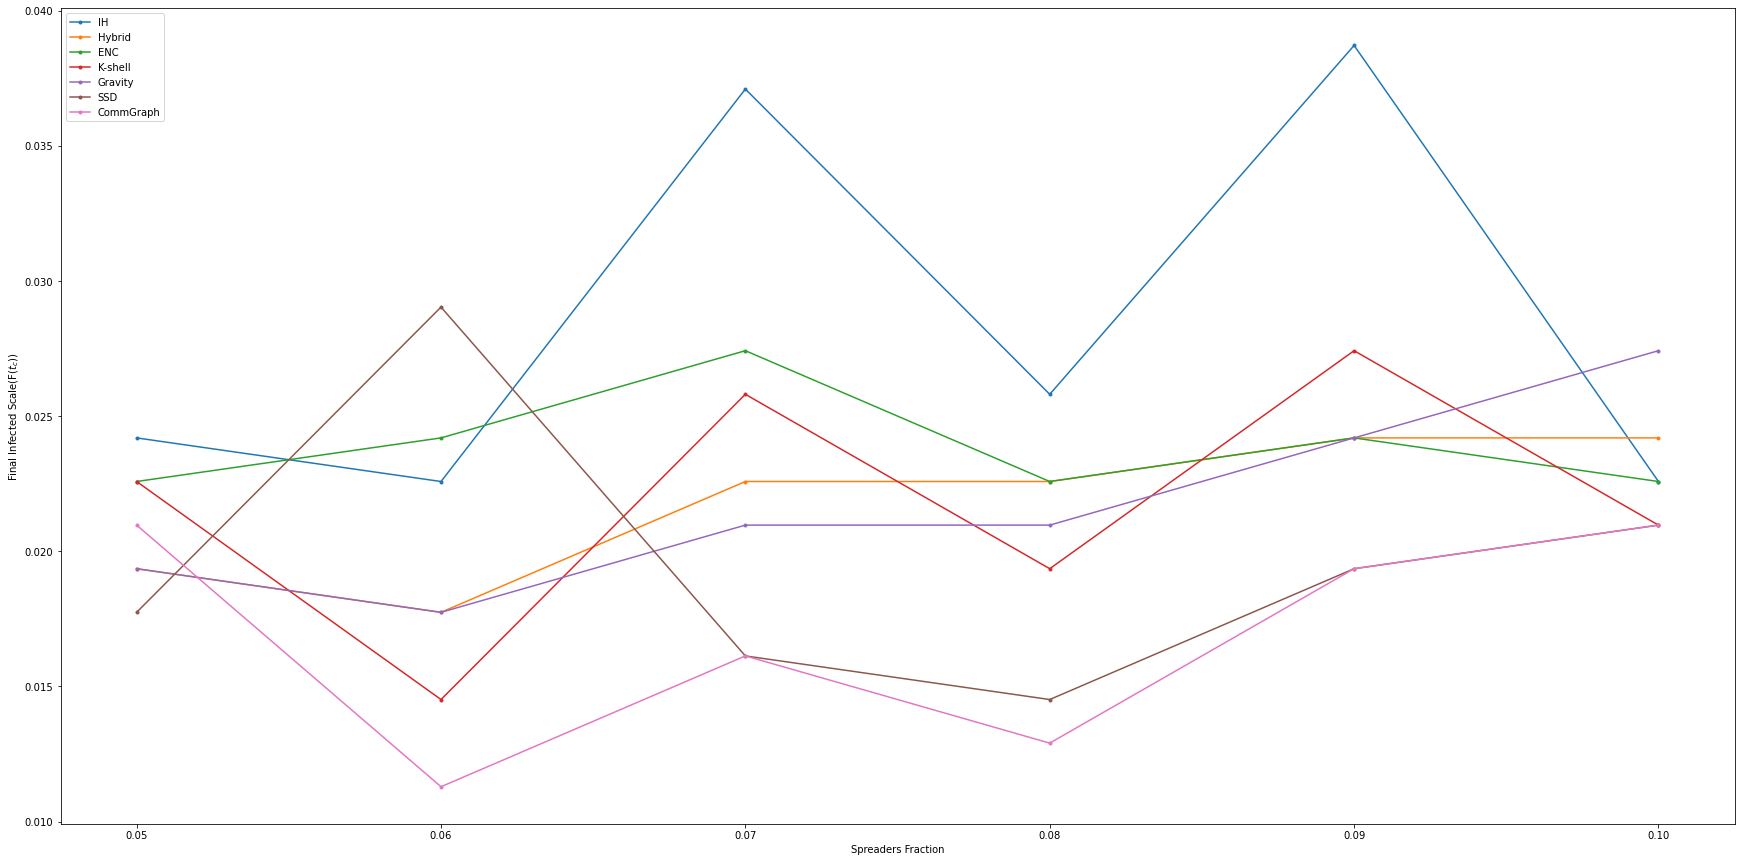

In [50]:
if __name__=="__main__": 
    simulations=10
    ftc1=list()   
    ftc2=list() 
    ftc3=list()  
    ftc4=list()  
    ftc5=list()   
    ftc6=list()
    ftc7=list()
    ftc8=list()
    ftc9=list()
    ftc10=list()

    ls1=list()    
    ls2=list()    
    ls3=list()  
    ls4=list()    
    ls5=list()     
    ls6=list() 
    ls7=list()  
    ls8=list()    
    ls9=list()
    ls10=list()
    
    g,data=CreateGraph()
    
    beta=beta_threshold(g)
    
    Comm_G,c,map_nodes=make_comm_graph(g,data)
    deg=calc_deg(g)
    Deg_Neigh=calc_neigh_deg(g)
    no_of_comm=calc_comm_attatched(g,map_nodes)
    Influence_power=calc_inf_power(g,Deg_Neigh,no_of_comm,deg)
    Comm_nodes_ratio=calc_CommNodes_ratio(g,c)
    nodes_inf_sorted=sort_acc_inf_power(c,Influence_power)
    total_nodes=g.number_of_nodes()
    if g.number_of_nodes()>2000:
        spreaders_fractions_list=[0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04]
    else:
        spreaders_fractions_list=[0.05,0.06,0.07,0.08,0.09,0.10]
   
    for fraction in spreaders_fractions_list:
        print(fraction)
        spreaders=int(g.number_of_nodes()*fraction)
        #case 10: comm graph
        spreaders_list_coreness_eigen=FindSpreaders1(fraction,c,total_nodes,nodes_inf_sorted)
        print(len(spreaders_list_coreness_eigen))
        infected_scale,ftc=SIRModel(g, spreaders_list_coreness_eigen,beta,simulations)
        ftc10.append(ftc/simulations)    
        ls=SPL(g,spreaders_list_coreness_eigen)
        ls10.append(ls)
        # CASE1: IMPROVED CORENESS * EIGEN VECTOR CENTRALITY
        spreaders=int(g.number_of_nodes()*fraction)
        G=g.copy()
        k_shell=nx.core_number(g)
        coreness=Coreness(G,k_shell)
        extended_coreness=Extended_Coreness(G,coreness)
        eigen_vector_centrality=Eigen_Vector_Centrality(G)
        hybrid_centrality=Hybrid_Centrality(G,coreness,eigen_vector_centrality)   
        spreaders_list_coreness_eigen=FindSpreaders(G,hybrid_centrality,spreaders)
        infected_scale,ftc=SIRModel(G,spreaders_list_coreness_eigen,beta,simulations) 
        ftc1.append(ftc/simulations)    
        ls=SPL(g,spreaders_list_coreness_eigen)
        ls1.append(ls)
        #print("ICC done")

       #CASE2: EIGEN VECTOR CENTRALITY
        eigen_vector_centrality=Eigen_Vector_Centrality(G)
        spreaders_list_eigen=Find_Spreaders(G,eigen_vector_centrality,spreaders)
        infected_scale,ftc=SIRModel(G,spreaders_list_eigen,beta,simulations)
        ftc2.append(ftc/simulations)
        ls=SPL(g,spreaders_list_eigen)
        ls2.append(ls)
      #  print("Eigen done")


        #CASE4 K-SHELL CENTRALITY 
        spreaders_list_k_shell=Find_Spreaders(G,k_shell,spreaders)
        infected_scale,ftc=SIRModel(G,spreaders_list_k_shell,beta,simulations)
        ftc4.append(ftc/simulations)
        ls=SPL(g,spreaders_list_k_shell)
        ls4.append(ls)
        #print("k-shell done")


       # CASE 5: EXTENDED CORENESS * H-INDEX   
        h_index=H_Index(G) 
        hybrid_centrality=Hybrid_Centrality(G,extended_coreness,h_index)   
        spreaders_list_extended_coreness_h_index=FindSpreaders(G,hybrid_centrality,spreaders)
        infected_scale,ftc=SIRModel(G,spreaders_list_extended_coreness_h_index,beta,simulations)
        ftc5.append(ftc/simulations)
        ls=SPL(g,spreaders_list_extended_coreness_h_index)
        ls5.append(ls)
       # print("improved hybrid done")

        #CASE 6: EXTENDED_CORENESS
        spreaders_list_extended_coreness=Find_Spreaders(G,extended_coreness,spreaders)
        infected_scale,ftc=SIRModel(G,spreaders_list_extended_coreness,beta,simulations)
        ftc6.append(ftc/simulations)
        ls=SPL(g,spreaders_list_extended_coreness)
        ls6.append(ls)
        #print('extended coreness done')  

        #CASE 7: ARKA SIR
        eigen=Eigen_Vector_Centrality(g)
        degree=Degree_Centrality(g)
        page=nx.pagerank(g)
        n_degree=dict()
        mean=np.array(list(degree.values())).mean()
        sd=np.array(list(degree.values())).std()
        for node in g.nodes():
            n_degree[node]=(degree[node]-mean)/sd

        n_eigen=dict()
        mean=np.array(list(eigen.values())).mean()
        sd=np.array(list(eigen.values())).std()
        for node in g.nodes():
            n_eigen[node]=(eigen[node]-mean)/sd

        n_page=dict()
        mean=np.array(list(page.values())).mean()
        sd=np.array(list(page.values())).std()
        for node in g.nodes():
            n_page[node]=(page[node]-mean)/sd

        master=dict()
        for node in g.nodes():
            master[node]=n_degree[node]+n_eigen[node]+n_page[node]       
        spreaders_list_sum=Find_Spreaders(G,master,spreaders)
        infected_scale,ftc=SIRModel(G,spreaders_list_sum,beta,simulations)
        ftc8.append(ftc/simulations)
        ls=SPL(g,spreaders_list_sum)
        ls8.append(ls)
       # print('Sum done')  


       #Gravity
        k_shell = nx.core_number(g) 
        grav_k_shell = gravity(g,k_shell,r=2)
        spreaders_list_grav_k_shell=Find_Spreaders(g,grav_k_shell,spreaders)
        infected_scale,ftc=SIRModel(g,spreaders_list_grav_k_shell,beta,simulations)
        ftc9.append(ftc/simulations)   
        ls=SPL(g,spreaders_list_grav_k_shell)
        ls9.append(ls)
        print("grav_k_shell done")

    plt.plot(spreaders_fractions_list,ftc5,label='IH',marker='.')
    plt.plot(spreaders_fractions_list,ftc1,label='Hybrid',marker='.')  
    plt.plot(spreaders_fractions_list,ftc6,label='ENC',marker='.')
    plt.plot(spreaders_fractions_list,ftc4,label='K-shell',marker='.')
    #plt.plot(spreaders_fractions_list,ftc2,label='Eigen',marker='.')
    plt.plot(spreaders_fractions_list,ftc9,label='Gravity',marker='.')
    plt.plot(spreaders_fractions_list,ftc8,label='SSD',marker='.')
    # plt.plot(xnew3[:-35],power_smooth3[:-35],label='degree')
    plt.plot(spreaders_fractions_list,ftc10,label='CommGraph',marker='.')    
    plt.ylabel("Final Infected Scale(F($t_c$))")
    plt.xlabel("Spreaders Fraction")
    plt.legend(loc=2)
    plt.show() 